In [1]:
# ruff: noqa: F401

In [2]:
%load_ext autoreload
%load_ext pyinstrument

%autoreload 2

In [3]:
import sys

sys.path.insert(0, "..")

In [4]:
from datetime import datetime, timedelta
from pathlib import Path

import hvplot.polars
import numpy as np
import polars as pl

In [5]:
from tsdb_benchmarks.monetdb import MonetDB
from tsdb_benchmarks.monetdb.fetch import fetch_binary, fetch_pymonetdb
from tsdb_benchmarks.monetdb.insert import insert
from tsdb_benchmarks.monetdb.utils import drop_table

db = MonetDB()

In [13]:
df = pl.read_parquet("../data/input/data_0.2M_0.5k.parquet").with_columns(
    (100 * pl.col.col_1 - 50).cast(pl.Int8).alias("col_1_int8"),
    (100 * pl.col.col_1 - 50).cast(pl.Int16).alias("col_1_int16"),
    (100 * pl.col.col_1 - 50).cast(pl.Int32).alias("col_1_int32"),
    (100 * pl.col.col_1 - 50).cast(pl.Int64).alias("col_1_int64"),
    pl.col.col_1.cast(pl.Float32).alias("col_1_float32"),
    pl.col.col_1.cast(pl.Float64).alias("col_1_float64"),
    pl.col.col_1.cast(pl.String).alias("col_1_str"),
    (pl.col.col_1 > 0.5).cast(pl.Boolean).alias("col_1_bool"),
    pl.col.col_1.cast(pl.Binary).alias("col_1_blob"),
    ('{ "val": ' + pl.col.col_1.cast(pl.String) + "}").alias("col_1_json"),
    pl.col.time.cast(pl.Time).alias("time_time"),
    pl.col.time.cast(pl.Date).alias("time_date"),
)


df = df.with_columns(
    pl.when((pl.col.time > df.get_column("time")[4]) | (pl.col.time == df.get_column("time")[0]))
    .then(pl.col(n))
    .otherwise(None)
    for n in df.columns
    if n != "time"
)

# df = df.select([n for n in df.columns if n == "time" or n.count("_") == 2])

df

time,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,…,col_476,col_477,col_478,col_479,col_480,col_481,col_482,col_483,col_484,col_485,col_486,col_487,col_488,col_489,col_490,col_491,col_492,col_493,col_494,col_495,col_496,col_497,col_498,col_499,col_500,col_1_int8,col_1_int16,col_1_int32,col_1_int64,col_1_float32,col_1_float64,col_1_str,col_1_bool,col_1_blob,col_1_json,time_time,time_date
datetime[ms],f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,i32,i64,f32,f64,str,bool,binary,str,time,date
2024-08-15 02:41:00,0.524554,0.477075,0.301365,0.086035,0.597285,0.043119,0.133568,0.461486,0.698985,0.373141,0.441279,0.948216,0.824963,0.751381,0.239386,0.646477,0.642296,0.742751,0.889037,0.010748,0.652077,0.617199,0.874318,0.379782,0.882789,0.131134,0.584154,0.460211,0.453917,0.183285,0.792429,0.057061,0.568505,0.415087,0.68145,0.299985,…,0.557787,0.216671,0.915053,0.721279,0.844078,0.208799,0.475463,0.299425,0.27852,0.306467,0.955012,0.889113,0.301954,0.543857,0.257937,0.726755,0.120436,0.639036,0.332407,0.065476,0.736886,0.242331,0.73887,0.265512,0.579258,2,2,2,2,0.524554,0.524554,"""0.52455395""",true,"b""0.52455395""","""{ ""val"": 0.52455395}""",02:41:00,2024-08-15
2024-08-15 02:42:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:43:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:44:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:45:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-31 23:56:00,0.140222,0.525429,0.503118,0.323336,0.770159,0.988965,0.026295,0.027552,0.19186,0.904292,0.477865,0.477788,0.255188,0.973056,0.951939,0.579024,0.700732,0.131963,0.840651,0.546734,0.361591,0.63238,0.090908,0.292023,0.907075,0.252858,0.539729,0.743791,0.517861,0.28477,0.032481,0.415767,0.750808,0.026333,0.843167,0.856345,…,0.741329,0.197616,0.461123,0.144307,0.770002,0.179262,0.390588,0.706254,0.767351,0.978795,0.838259,0.179567,0.017982,0.360384,0.317142,0.232748,0.696122,0.45992,0.339463,0.66594,0.864443,0.401472,0.515272,0.065308,0.879162,-35,-35,-35,-35,0.140222,0.140222,"""0.14022161""",false,"b""0.14022161""","""{ ""val"": 0.14022161}""",23:56:00,2024-12-31
2024-12-31 23:57:00,0.551554,

In [14]:
drop_table("test_insert", db.connect())

In [15]:
insert(df, "test_insert", db.connect(), primary_key="time", json_columns="col_1_json")

In [17]:
fetch_binary("select * from test_insert order by time", db.connect())

time,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,…,col_476,col_477,col_478,col_479,col_480,col_481,col_482,col_483,col_484,col_485,col_486,col_487,col_488,col_489,col_490,col_491,col_492,col_493,col_494,col_495,col_496,col_497,col_498,col_499,col_500,col_1_int8,col_1_int16,col_1_int32,col_1_int64,col_1_float32,col_1_float64,col_1_str,col_1_bool,col_1_blob,col_1_json,time_time,time_date
datetime[ms],f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,i32,i64,f32,f64,str,bool,binary,object,time,date
2024-08-15 02:41:00,0.524554,0.477075,0.301365,0.086035,0.597285,0.043119,0.133568,0.461486,0.698985,0.373141,0.441279,0.948216,0.824963,0.751381,0.239386,0.646477,0.642296,0.742751,0.889037,0.010748,0.652077,0.617199,0.874318,0.379782,0.882789,0.131134,0.584154,0.460211,0.453917,0.183285,0.792429,0.057061,0.568505,0.415087,0.68145,0.299985,…,0.557787,0.216671,0.915053,0.721279,0.844078,0.208799,0.475463,0.299425,0.27852,0.306467,0.955012,0.889113,0.301954,0.543857,0.257937,0.726755,0.120436,0.639036,0.332407,0.065476,0.736886,0.242331,0.73887,0.265512,0.579258,2,2,2,2,0.524554,0.524554,"""0.52455395""",true,"b""0.52455395""",{'val': 0.52455395},02:41:00,2024-08-15
2024-08-15 02:42:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:43:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:44:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:45:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-31 23:56:00,0.140222,0.525429,0.503118,0.323336,0.770159,0.988965,0.026295,0.027552,0.19186,0.904292,0.477865,0.477788,0.255188,0.973056,0.951939,0.579024,0.700732,0.131963,0.840651,0.546734,0.361591,0.63238,0.090908,0.292023,0.907075,0.252858,0.539729,0.743791,0.517861,0.28477,0.032481,0.415767,0.750808,0.026333,0.843167,0.856345,…,0.741329,0.197616,0.461123,0.144307,0.770002,0.179262,0.390588,0.706254,0.767351,0.978795,0.838259,0.179567,0.017982,0.360384,0.317142,0.232748,0.696122,0.45992,0.339463,0.66594,0.864443,0.401472,0.515272,0.065308,0.879162,-35,-35,-35,-35,0.140222,0.140222,"""0.14022161""",false,"b""0.14022161""",{'val': 0.14022161},23:56:00,2024-12-31
2024-12-31 23:57:00,0.551554,0.155373,0.0598

_     ._   __/__   _ _  _  _ _/_   Recorded: 11:32:48  Samples:  1566
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.527     CPU time: 1.378
/   _/                      v5.0.2

Cell [18]

2.526 <module>  /var/folders/wt/2s8cn3zn1nndhbq08y2cjm500000gn/T/ipykernel_87329/3424466494.py:1
|- 2.488 insert  tsdb_benchmarks/monetdb/insert.py:168
|  |- 1.493 Connection.execute  pymonetdb/sql/connections.py:213
|  |     [34 frames hidden]  pymonetdb, <built-in>
|  |- 0.773 write_binary_column_data  tsdb_benchmarks/monetdb/insert.py:135
|  |  |- 0.265 write_numeric_column  tsdb_benchmarks/monetdb/insert.py:37
|  |  |  `- 0.213 Series.wrapper  polars/series/utils.py:99
|  |  |        [5 frames hidden]  polars, <built-in>
|  |  |- 0.137 write_string_column  tsdb_benchmarks/monetdb/insert.py:54
|  |  |  |- 0.054 [self]  tsdb_benchmarks/monetdb/insert.py
|  |  |  |- 0.032 str.encode  <built-in>
|  |  |  `- 0.027 Series.__iter__  polars/series/series.py:1336
|  |  |- 0.101 write_datetime_column  tsdb_benchmarks/monetdb/insert.py:85
|  |  |  |- 0.034 [self]  tsdb_benchmarks/monetdb/insert.py
|  |  |  `- 0.032 Series.__iter__  polars/series/series.py:1336
|  |  |- 0.098 write_binary_column  tsdb_benchmarks/monetdb/insert.py:125
|  |  |  |- 0.039 [self]  tsdb_benchmarks/monetdb/insert.py
|  |  |  `- 0.033 BufferedWriter.write  <built-in>
|  |  |- 0.094 write_time_column  tsdb_benchmarks/monetdb/insert.py:72
|  |  |  |- 0.030 BufferedWriter.write  <built-in>
|  |  |  `- 0.029 [self]  tsdb_benchmarks/monetdb/insert.py
|  |  `- 0.077 write_date_column  tsdb_benchmarks/monetdb/insert.py:63
|  |- 0.171 Connection.commit  pymonetdb/sql/connections.py:177
|  |     [9 frames hidden]  pymonetdb, <built-in>
|  `- 0.029 rmtree  shutil.py:710
|        [2 frames hidden]  shutil, <built-in>
`- 0.038 drop_table  tsdb_benchmarks/monetdb/utils.py:199
   `- 0.032 Connection.execute  sqlalchemy/engine/base.py:1371
         [14 frames hidden]  sqlalchemy, pymonetdb, <built-in>
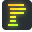

In [18]:
%%pyinstrument

drop_table("test_insert", db.connect())
insert(df, "test_insert", db.connect(), primary_key="time", json_columns="col_1_json")

* JSON is read differently by binary and pymonetdb due to a bug in pymonetdb (ignore `col_1_json`)


In [11]:
fetch_pymonetdb("select * from test_insert order by time", db.connect()).drop("col_1_json").equals(
    fetch_binary("select * from test_insert order by time", db.connect()).drop("col_1_json")
)

True

In [12]:
fetch_binary("select * from test_insert order by time", db.connect()).drop("col_1_json").equals(
    df.drop("col_1_json").sort("time")
)

True